In [ ]:
Task-3

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from dateutil.parser import parse



In [83]:
from dateutil.parser import parse

# Step 1: Parse and strip timezone (fully tz-naive)
def try_parse_date(s):
    try:
        dt = parse(s, fuzzy=True)
        return dt.replace(tzinfo=None)  # force tz-naive
    except:
        return pd.NaT

# Step 2: Apply to column
df_news = pd.read_csv("/content/sentiment_dataset.csv")
df_news['timestamp'] = df_news['date'].apply(try_parse_date)

# Step 3: Drop bad rows
df_news = df_news.dropna(subset=['timestamp', 'compound'])

# Step 4: Convert to pandas datetime and normalize to date only
df_news['timestamp'] = pd.to_datetime(df_news['timestamp'])
df_news['timestamp'] = df_news['timestamp'].dt.normalize()


In [108]:
tickers = df_news['stock'].unique().tolist()
print(tickers)
print(df_news['timestamp'].head())
print(df_news['stock'].unique())
print(df_news[df_news['stock'] == 'MS'].shape[0])



['A', 'AA', 'AAC', 'AADR', 'AAL', 'AAMC', 'AAME', 'AAN', 'AAOI', 'AAON', 'AAP', 'AAPL', 'AAU', 'AAV', 'AAVL', 'AAWW', 'AAXJ', 'AB', 'ABAC', 'ABAX', 'ABB', 'ABBV', 'ABC', 'ABCB', 'ABCD', 'ABCO', 'ABCW', 'ABDC', 'ABEV', 'ABG', 'ABGB', 'ABIO', 'ABM', 'ABMD', 'ABR', 'ABTL', 'ABX', 'ABY', 'ACAD', 'ACAS', 'ACAT', 'ACC', 'ACCO', 'ACCU', 'ACE', 'ACET', 'ACFC', 'ACFN', 'ACG', 'ACGL', 'ACH', 'ACHC', 'ACHN', 'ACIW', 'ACLS', 'ACM', 'ACMP', 'ACN', 'ACNB', 'ACOR', 'ACP', 'ACPW', 'ACRE', 'ACRX', 'ACSF', 'ACST', 'ACT', 'ACTA', 'ACTG', 'ACTS', 'ACU', 'ACUR', 'ACWI', 'ACWV', 'ACWX', 'ACXM', 'ACY', 'ADAT', 'ADBE', 'ADC', 'ADEP', 'ADES', 'ADGE', 'ADHD', 'ADI', 'ADK', 'ADM', 'ADMA', 'ADMP', 'ADMS', 'ADNC', 'ADP', 'ADPT', 'ADRA', 'ADRD', 'ADRE', 'ADRU', 'ADS', 'ADSK', 'ADT', 'ADTN', 'ADVS', 'ADX', 'ADXS', 'ADZ', 'AE', 'AEB', 'AEC', 'AEE', 'AEG', 'AEGN', 'AEGR', 'AEHR', 'AEIS', 'AEL', 'AEM', 'AEO', 'AEPI', 'AER', 'AERI', 'AES', 'AET', 'AETI', 'AEY', 'AEZS', 'AF', 'AFA', 'AFAM', 'AFB', 'AFC', 'AFCB', 'AFFX', 

In [87]:
df_aapl = pd.read_csv("/content/AAPL_historical_data.csv", parse_dates=['Date'])
df_aapl.set_index('Date', inplace=True)
df_aapl.index = pd.to_datetime(df_aapl.index).normalize()
df_aapl = df_aapl[['Close']].sort_index()
df_aapl.head()

aapl_news = df_news[df_news['stock'] == 'AAPL'].copy()

row = aapl_news.iloc[0]
event_date = row['timestamp']
after_date = event_date + pd.Timedelta(days=1)

print("Event date:", event_date)
print("In AAPL data:", event_date in df_aapl.index)
print("Next day:", after_date)
print("Next day in AAPL data:", after_date in df_aapl.index)



Event date: 2020-06-10 00:00:00
In AAPL data: True
Next day: 2020-06-11 00:00:00
Next day in AAPL data: True


In [88]:
def get_price_change_aapl(row, price_df, days_after=1):
    try:

        event_date = row['timestamp']
        after_date = event_date + pd.Timedelta(days=days_after)


        price_df = price_df.sort_index()


        start_date = price_df.index[price_df.index >= event_date]
        end_date = price_df.index[price_df.index >= after_date]

        if not start_date.empty and not end_date.empty:
            price_before = price_df.loc[start_date[0], 'Close']
            price_after = price_df.loc[end_date[0], 'Close']
            return (price_after - price_before) / price_before
        else:
            return np.nan
    except:
        return np.nan

aapl_news['return_1d'] = aapl_news.apply(lambda row: get_price_change_aapl(row, df_aapl), axis=1)

valid = aapl_news.dropna(subset=['return_1d'])
print("✅ Rows with valid return:", valid.shape[0])
valid[['timestamp', 'compound', 'return_1d']].head()


✅ Rows with valid return: 441


,timestamp,compound,return_1d
6680,2020-06-10,0.5574,-0.04801
6681,2020-06-10,0.0000,-0.04801
6682,2020-06-10,0.2023,-0.04801
6683,2020-06-10,0.0000,-0.04801
6684,2020-06-10,0.3818,-0.04801


In [89]:
pearson_corr = valid['compound'].corr(valid['return_1d'], method='pearson')
spearman_corr = valid['compound'].corr(valid['return_1d'], method='spearman')

print(f"📈 Pearson Correlation: {pearson_corr:.4f}")
print(f"📈 Spearman Correlation: {spearman_corr:.4f}")


📈 Pearson Correlation: -0.0363
📈 Spearman Correlation: -0.0561


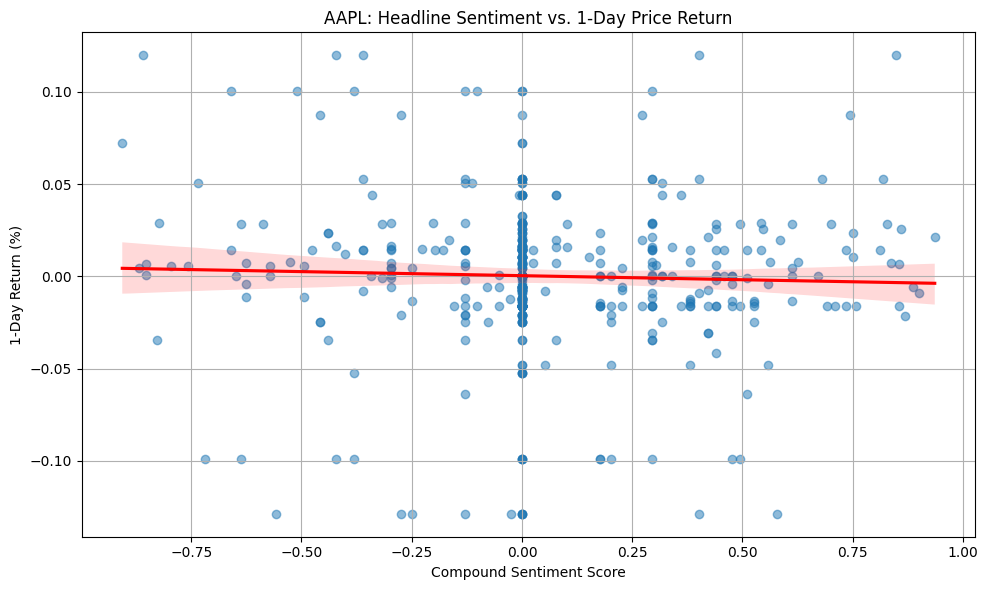

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.regplot(data=valid, x='compound', y='return_1d', scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('AAPL: Headline Sentiment vs. 1-Day Price Return')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('1-Day Return (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


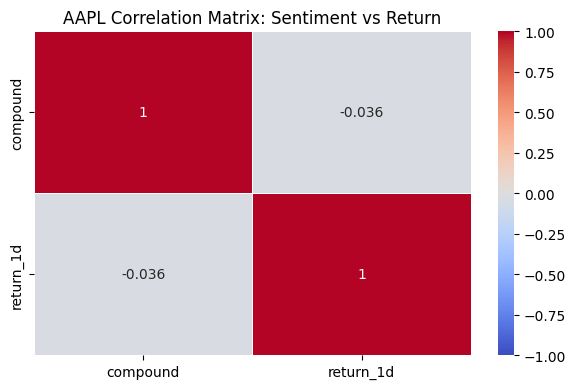

In [91]:

correlation_data = valid[['compound', 'return_1d']]


corr_matrix = correlation_data.corr(method='pearson')


plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title("AAPL Correlation Matrix: Sentiment vs Return")
plt.tight_layout()
plt.show()


# **AMZN Data**

Event date: 2020-06-10 00:00:00
In amzn data: True
Next day: 2020-06-11 00:00:00
Next day in amzn data: True
✅ Rows with valid return: 278
📈 Pearson Correlation: -0.1178
📈 Spearman Correlation: -0.0994


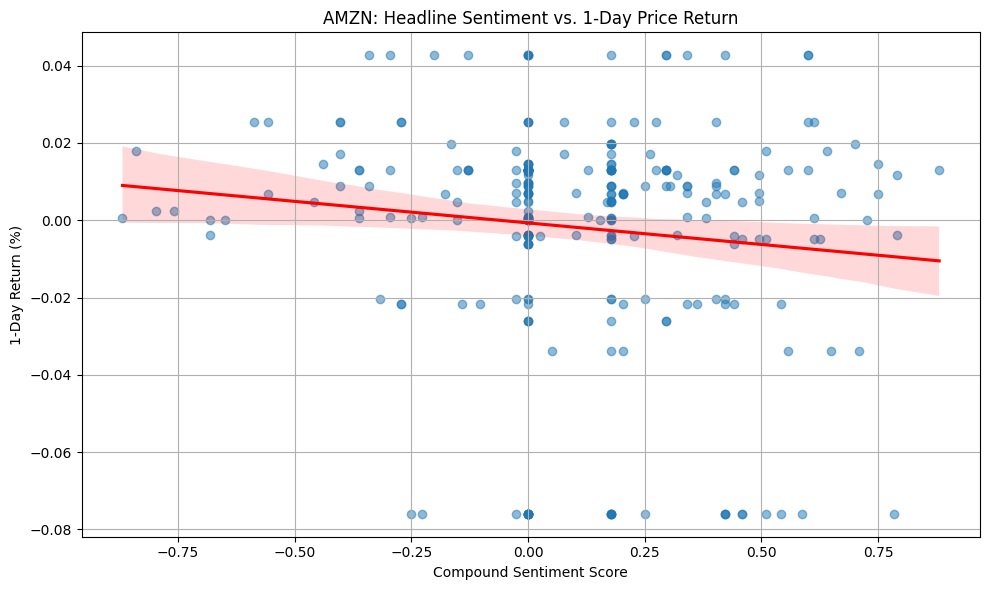

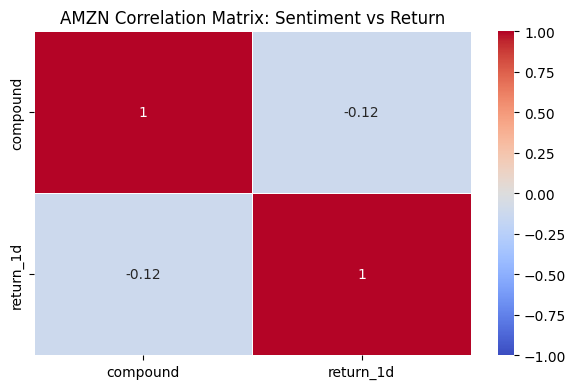

In [92]:
df_amzn = pd.read_csv("/content/AMZN_historical_data.csv", parse_dates=['Date'])
df_amzn.set_index('Date', inplace=True)
df_amzn.index = pd.to_datetime(df_amzn.index).normalize()
df_amzn = df_amzn[['Close']].sort_index()
df_amzn.head()


amzn_news = df_news[df_news['stock'] == 'AMZN'].copy()

row = amzn_news.iloc[0]
event_date = row['timestamp']
after_date = event_date + pd.Timedelta(days=1)

print("Event date:", event_date)
print("In amzn data:", event_date in df_amzn.index)
print("Next day:", after_date)
print("Next day in amzn data:", after_date in df_amzn.index)


def get_price_change_amzn(row, price_df, days_after=1):
    try:

        event_date = row['timestamp']
        after_date = event_date + pd.Timedelta(days=days_after)


        price_df = price_df.sort_index()


        start_date = price_df.index[price_df.index >= event_date]
        end_date = price_df.index[price_df.index >= after_date]

        if not start_date.empty and not end_date.empty:
            price_before = price_df.loc[start_date[0], 'Close']
            price_after = price_df.loc[end_date[0], 'Close']
            return (price_after - price_before) / price_before
        else:
            return np.nan
    except:
        return np.nan

amzn_news['return_1d'] = amzn_news.apply(lambda row: get_price_change_amzn(row, df_amzn), axis=1)

valid = amzn_news.dropna(subset=['return_1d'])
print("✅ Rows with valid return:", valid.shape[0])
valid[['timestamp', 'compound', 'return_1d']].head()


pearson_corr = valid['compound'].corr(valid['return_1d'], method='pearson')
spearman_corr = valid['compound'].corr(valid['return_1d'], method='spearman')

print(f"📈 Pearson Correlation: {pearson_corr:.4f}")
print(f"📈 Spearman Correlation: {spearman_corr:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.regplot(data=valid, x='compound', y='return_1d', scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('AMZN: Headline Sentiment vs. 1-Day Price Return')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('1-Day Return (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


correlation_data = valid[['compound', 'return_1d']]


corr_matrix = correlation_data.corr(method='pearson')


plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title("AMZN Correlation Matrix: Sentiment vs Return")
plt.tight_layout()
plt.show()


# GOOG **Data**

Event date: 2020-06-10 00:00:00
In goog data: True
Next day: 2020-06-11 00:00:00
Next day in goog data: True
✅ Rows with valid return: 2778
📈 Pearson Correlation: 0.0008
📈 Spearman Correlation: 0.0183


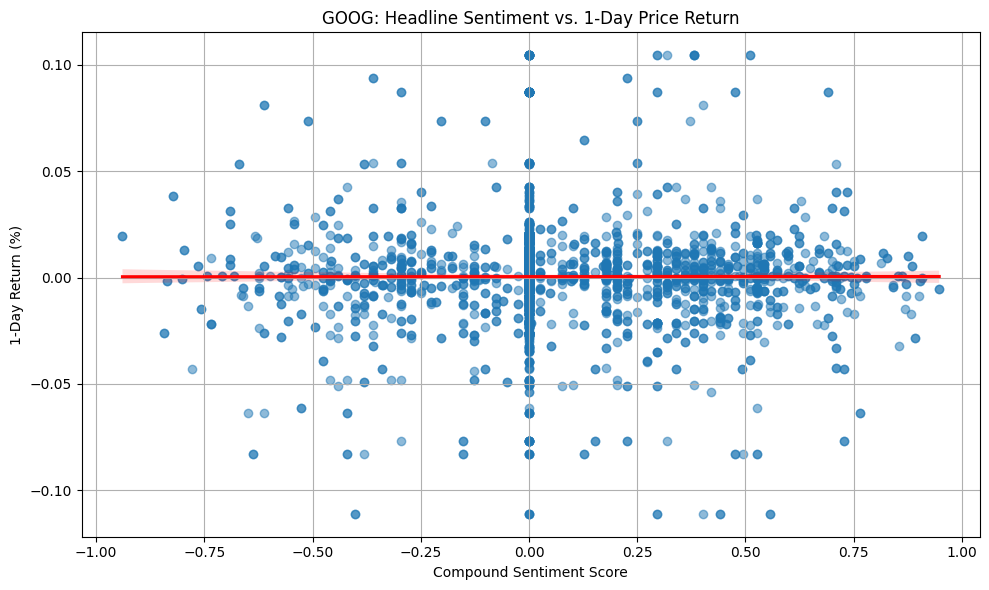

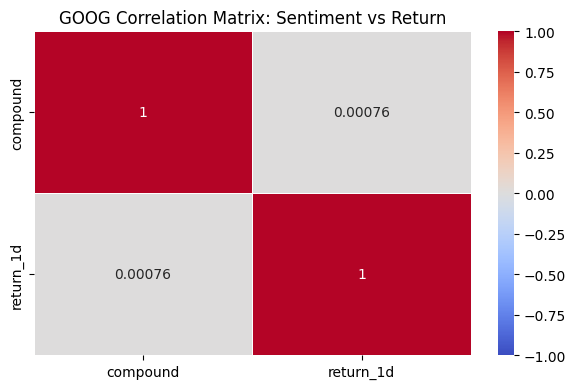

In [105]:
df_goog = pd.read_csv("/content/GOOG_historical_data.csv", parse_dates=['Date'])
df_goog.set_index('Date', inplace=True)
df_goog.index = pd.to_datetime(df_goog.index).normalize()
df_goog = df_goog[['Close']].sort_index()
df_goog.head()

goog_news1 = df_news[df_news['stock'] == 'GOOG'].copy()
goog_news = df_news[df_news['stock'] == 'GOOGL'].copy()
goog_news = pd.concat([goog_news1, goog_news])

row = goog_news.iloc[0]
event_date = row['timestamp']
after_date = event_date + pd.Timedelta(days=1)

print("Event date:", event_date)
print("In goog data:", event_date in df_goog.index)
print("Next day:", after_date)
print("Next day in goog data:", after_date in df_goog.index)


def get_price_change_goog(row, price_df, days_after=1):
    try:

        event_date = row['timestamp']
        after_date = event_date + pd.Timedelta(days=days_after)


        price_df = price_df.sort_index()


        start_date = price_df.index[price_df.index >= event_date]
        end_date = price_df.index[price_df.index >= after_date]

        if not start_date.empty and not end_date.empty:
            price_before = price_df.loc[start_date[0], 'Close']
            price_after = price_df.loc[end_date[0], 'Close']
            return (price_after - price_before) / price_before
        else:
            return np.nan
    except:
        return np.nan

goog_news['return_1d'] = goog_news.apply(lambda row: get_price_change_goog(row, df_goog), axis=1)

valid = goog_news.dropna(subset=['return_1d'])
print("✅ Rows with valid return:", valid.shape[0])
valid[['timestamp', 'compound', 'return_1d']].head()


pearson_corr = valid['compound'].corr(valid['return_1d'], method='pearson')
spearman_corr = valid['compound'].corr(valid['return_1d'], method='spearman')

print(f"📈 Pearson Correlation: {pearson_corr:.4f}")
print(f"📈 Spearman Correlation: {spearman_corr:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.regplot(data=valid, x='compound', y='return_1d', scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('GOOG: Headline Sentiment vs. 1-Day Price Return')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('1-Day Return (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


correlation_data = valid[['compound', 'return_1d']]


corr_matrix = correlation_data.corr(method='pearson')


plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title("GOOG Correlation Matrix: Sentiment vs Return")
plt.tight_layout()
plt.show()


# META **Data**

Event date: 2020-06-10 00:00:00
In META data: True
Next day: 2020-06-11 00:00:00
Next day in META data: True
✅ Rows with valid return: 380
📈 Pearson Correlation: -0.1215
📈 Spearman Correlation: -0.1096


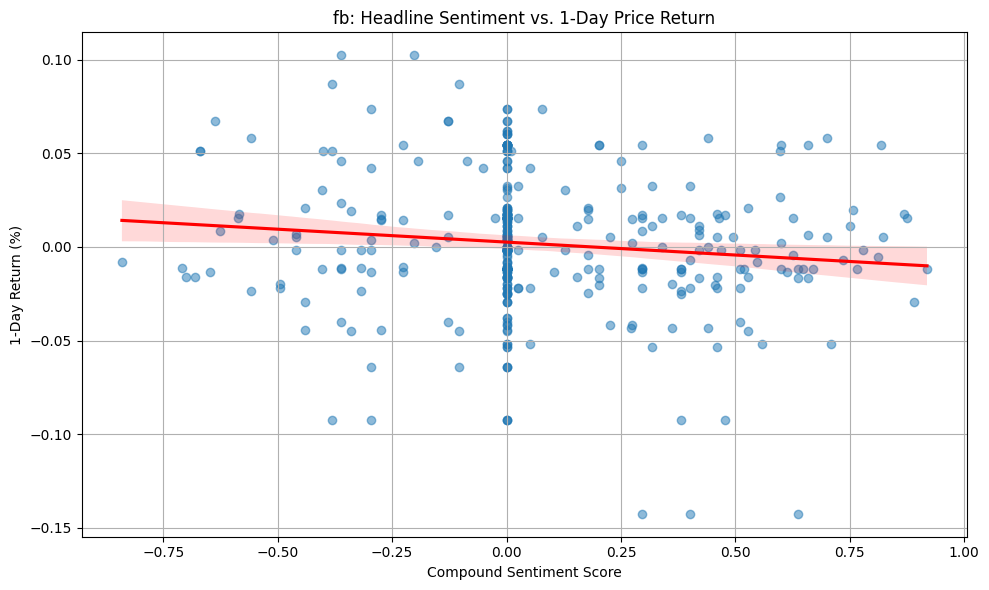

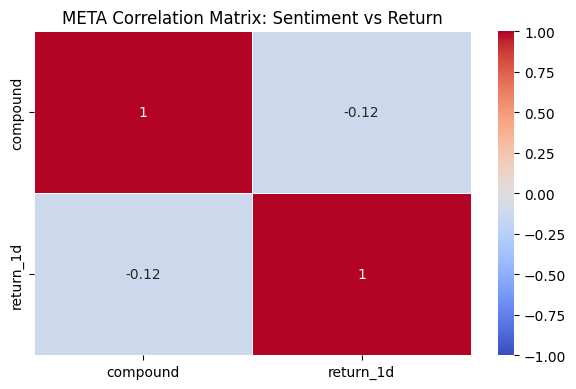

In [106]:
df_fb = pd.read_csv("/content/META_historical_data.csv", parse_dates=['Date'])
df_fb.set_index('Date', inplace=True)
df_fb.index = pd.to_datetime(df_fb.index).normalize()
df_fb = df_fb[['Close']].sort_index()
df_fb.head()

fb_news = df_news[df_news['stock'] == 'FB'].copy()

row = fb_news.iloc[0]
event_date = row['timestamp']
after_date = event_date + pd.Timedelta(days=1)

print("Event date:", event_date)
print("In META data:", event_date in df_fb.index)
print("Next day:", after_date)
print("Next day in META data:", after_date in df_fb.index)


def get_price_change_fb(row, price_df, days_after=1):
    try:

        event_date = row['timestamp']
        after_date = event_date + pd.Timedelta(days=days_after)


        price_df = price_df.sort_index()


        start_date = price_df.index[price_df.index >= event_date]
        end_date = price_df.index[price_df.index >= after_date]

        if not start_date.empty and not end_date.empty:
            price_before = price_df.loc[start_date[0], 'Close']
            price_after = price_df.loc[end_date[0], 'Close']
            return (price_after - price_before) / price_before
        else:
            return np.nan
    except:
        return np.nan

fb_news['return_1d'] = fb_news.apply(lambda row: get_price_change_fb(row, df_fb), axis=1)

valid = fb_news.dropna(subset=['return_1d'])
print("✅ Rows with valid return:", valid.shape[0])
valid[['timestamp', 'compound', 'return_1d']].head()


pearson_corr = valid['compound'].corr(valid['return_1d'], method='pearson')
spearman_corr = valid['compound'].corr(valid['return_1d'], method='spearman')

print(f"📈 Pearson Correlation: {pearson_corr:.4f}")
print(f"📈 Spearman Correlation: {spearman_corr:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.regplot(data=valid, x='compound', y='return_1d', scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('fb: Headline Sentiment vs. 1-Day Price Return')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('1-Day Return (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


correlation_data = valid[['compound', 'return_1d']]


corr_matrix = correlation_data.corr(method='pearson')


plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title("META Correlation Matrix: Sentiment vs Return")
plt.tight_layout()
plt.show()


# MSFT **Data**

Event date: 2020-06-11 00:00:00
In MSFT data: True
Next day: 2020-06-12 00:00:00
Next day in MSFT data: True
✅ Rows with valid return: 3238
📈 Pearson Correlation: -0.0378
📈 Spearman Correlation: -0.0235


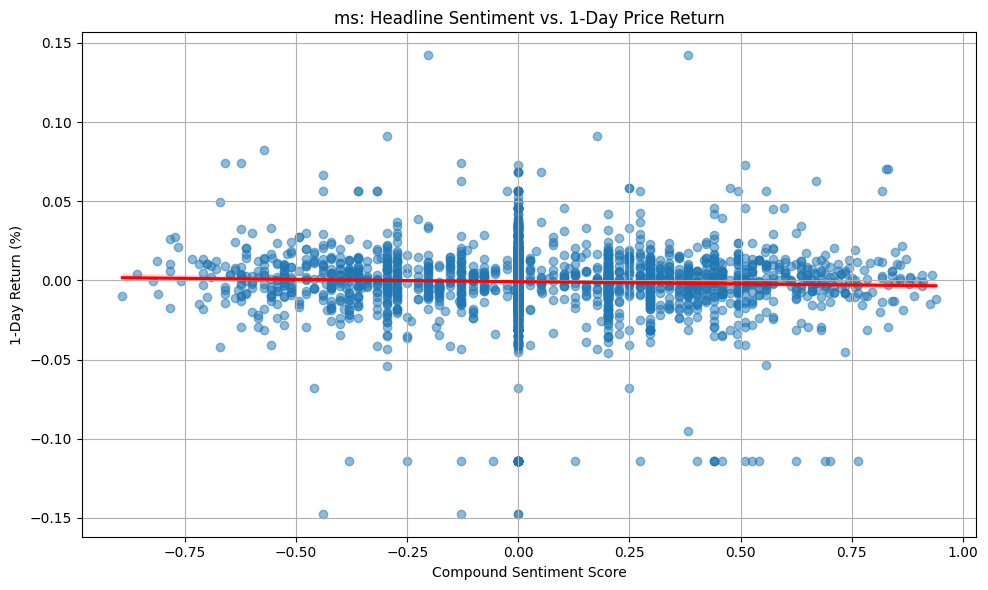

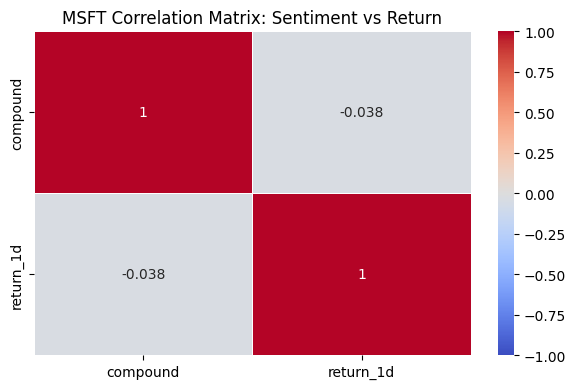

In [109]:
df_ms = pd.read_csv("/content/MSFT_historical_data.csv", parse_dates=['Date'])
df_ms.set_index('Date', inplace=True)
df_ms.index = pd.to_datetime(df_ms.index).normalize()
df_ms = df_ms[['Close']].sort_index()
df_ms.head()

ms_news = df_news[df_news['stock'] == 'MS'].copy()

row = ms_news.iloc[0]
event_date = row['timestamp']
after_date = event_date + pd.Timedelta(days=1)

print("Event date:", event_date)
print("In MSFT data:", event_date in df_ms.index)
print("Next day:", after_date)
print("Next day in MSFT data:", after_date in df_ms.index)


def get_price_change_ms(row, price_df, days_after=1):
    try:

        event_date = row['timestamp']
        after_date = event_date + pd.Timedelta(days=days_after)


        price_df = price_df.sort_index()


        start_date = price_df.index[price_df.index >= event_date]
        end_date = price_df.index[price_df.index >= after_date]

        if not start_date.empty and not end_date.empty:
            price_before = price_df.loc[start_date[0], 'Close']
            price_after = price_df.loc[end_date[0], 'Close']
            return (price_after - price_before) / price_before
        else:
            return np.nan
    except:
        return np.nan

ms_news['return_1d'] = ms_news.apply(lambda row: get_price_change_ms(row, df_ms), axis=1)

valid = ms_news.dropna(subset=['return_1d'])
print("✅ Rows with valid return:", valid.shape[0])
valid[['timestamp', 'compound', 'return_1d']].head()


pearson_corr = valid['compound'].corr(valid['return_1d'], method='pearson')
spearman_corr = valid['compound'].corr(valid['return_1d'], method='spearman')

print(f"📈 Pearson Correlation: {pearson_corr:.4f}")
print(f"📈 Spearman Correlation: {spearman_corr:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.regplot(data=valid, x='compound', y='return_1d', scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('MSFT: Headline Sentiment vs. 1-Day Price Return')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('1-Day Return (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


correlation_data = valid[['compound', 'return_1d']]


corr_matrix = correlation_data.corr(method='pearson')


plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title("MSFT Correlation Matrix: Sentiment vs Return")
plt.tight_layout()
plt.show()


# NVDA **Data**

Event date: 2020-06-10 00:00:00
In NVDA data: True
Next day: 2020-06-11 00:00:00
Next day in NVDA data: True
✅ Rows with valid return: 3146
📈 Pearson Correlation: -0.0089
📈 Spearman Correlation: -0.0007


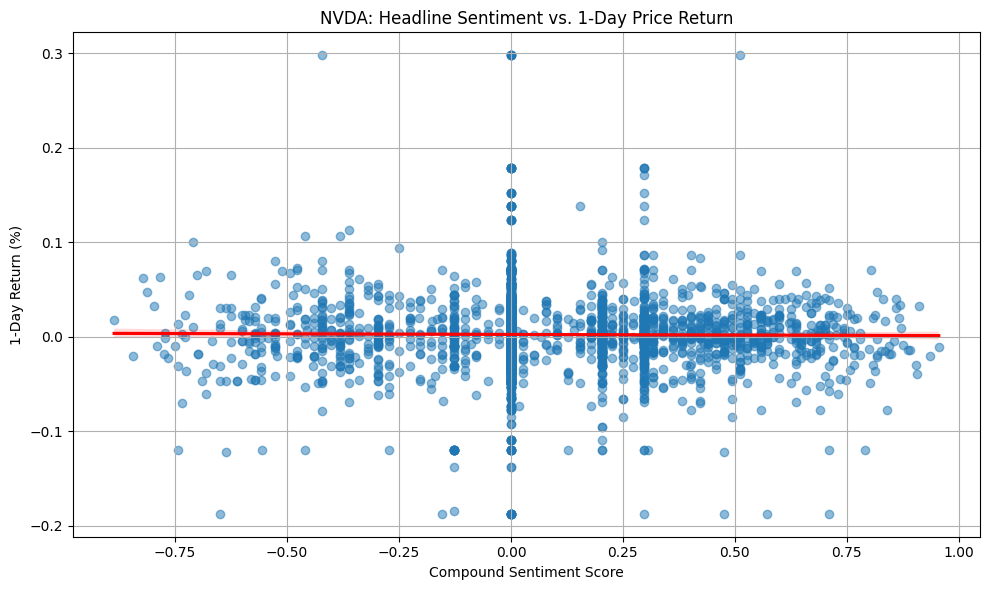

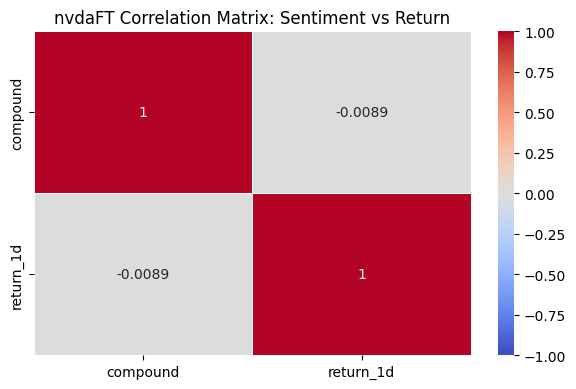

In [110]:
df_nvda = pd.read_csv("/content/NVDA_historical_data.csv", parse_dates=['Date'])
df_nvda.set_index('Date', inplace=True)
df_nvda.index = pd.to_datetime(df_nvda.index).normalize()
df_nvda = df_nvda[['Close']].sort_index()
df_nvda.head()

nvda_news = df_news[df_news['stock'] == 'NVDA'].copy()

row = nvda_news.iloc[0]
event_date = row['timestamp']
after_date = event_date + pd.Timedelta(days=1)

print("Event date:", event_date)
print("In NVDA data:", event_date in df_nvda.index)
print("Next day:", after_date)
print("Next day in NVDA data:", after_date in df_nvda.index)


def get_price_change_nvda(row, price_df, days_after=1):
    try:

        event_date = row['timestamp']
        after_date = event_date + pd.Timedelta(days=days_after)


        price_df = price_df.sort_index()


        start_date = price_df.index[price_df.index >= event_date]
        end_date = price_df.index[price_df.index >= after_date]

        if not start_date.empty and not end_date.empty:
            price_before = price_df.loc[start_date[0], 'Close']
            price_after = price_df.loc[end_date[0], 'Close']
            return (price_after - price_before) / price_before
        else:
            return np.nan
    except:
        return np.nan

nvda_news['return_1d'] = nvda_news.apply(lambda row: get_price_change_nvda(row, df_nvda), axis=1)

valid = nvda_news.dropna(subset=['return_1d'])
print("✅ Rows with valid return:", valid.shape[0])
valid[['timestamp', 'compound', 'return_1d']].head()


pearson_corr = valid['compound'].corr(valid['return_1d'], method='pearson')
spearman_corr = valid['compound'].corr(valid['return_1d'], method='spearman')

print(f"📈 Pearson Correlation: {pearson_corr:.4f}")
print(f"📈 Spearman Correlation: {spearman_corr:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.regplot(data=valid, x='compound', y='return_1d', scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('NVDA: Headline Sentiment vs. 1-Day Price Return')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('1-Day Return (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


correlation_data = valid[['compound', 'return_1d']]


corr_matrix = correlation_data.corr(method='pearson')


plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title("NVDA Correlation Matrix: Sentiment vs Return")
plt.tight_layout()
plt.show()


# TSLA **Data**

Event date: 2020-06-10 00:00:00
In TSLA data: True
Next day: 2020-06-11 00:00:00
Next day in TSLA data: True
✅ Rows with valid return: 1875
📈 Pearson Correlation: -0.0065
📈 Spearman Correlation: -0.0109


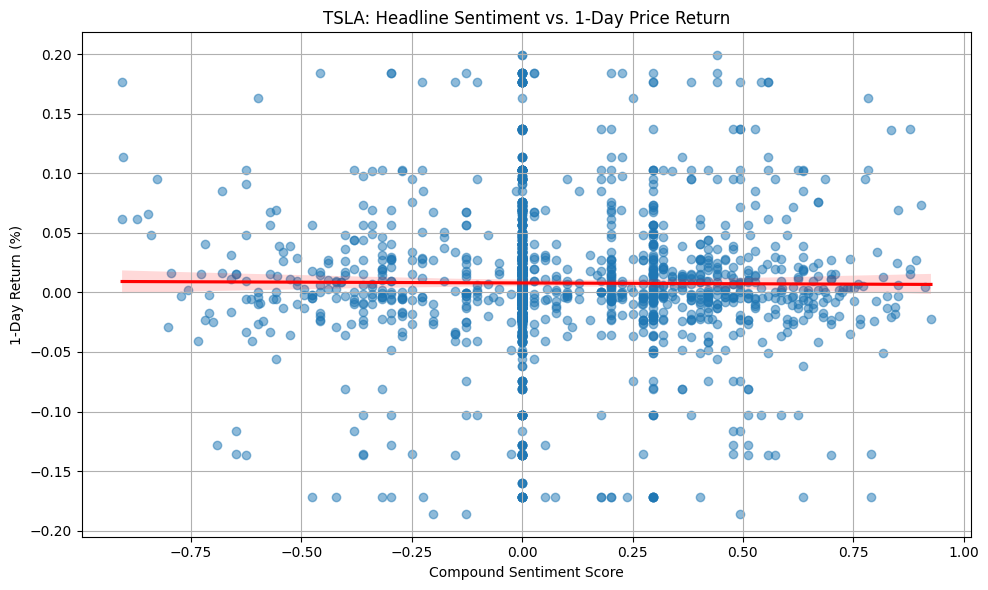

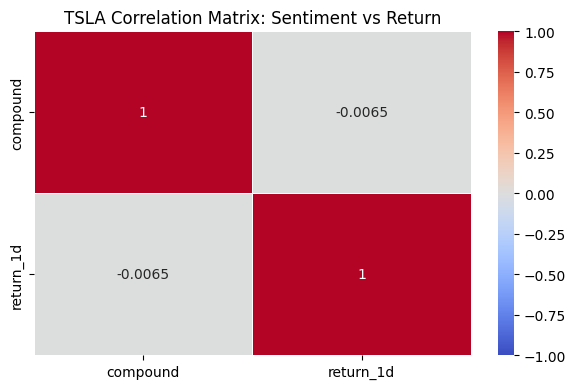

In [112]:
df_tsla = pd.read_csv("/content/TSLA_historical_data.csv", parse_dates=['Date'])
df_tsla.set_index('Date', inplace=True)
df_tsla.index = pd.to_datetime(df_tsla.index).normalize()
df_tsla = df_tsla[['Close']].sort_index()
df_tsla.head()

tsla_news = df_news[df_news['stock'] == 'TSLA'].copy()

row = tsla_news.iloc[0]
event_date = row['timestamp']
after_date = event_date + pd.Timedelta(days=1)

print("Event date:", event_date)
print("In TSLA data:", event_date in df_tsla.index)
print("Next day:", after_date)
print("Next day in TSLA data:", after_date in df_tsla.index)


def get_price_change_tsla(row, price_df, days_after=1):
    try:

        event_date = row['timestamp']
        after_date = event_date + pd.Timedelta(days=days_after)


        price_df = price_df.sort_index()


        start_date = price_df.index[price_df.index >= event_date]
        end_date = price_df.index[price_df.index >= after_date]

        if not start_date.empty and not end_date.empty:
            price_before = price_df.loc[start_date[0], 'Close']
            price_after = price_df.loc[end_date[0], 'Close']
            return (price_after - price_before) / price_before
        else:
            return np.nan
    except:
        return np.nan

tsla_news['return_1d'] = tsla_news.apply(lambda row: get_price_change_tsla(row, df_tsla), axis=1)

valid = tsla_news.dropna(subset=['return_1d'])
print("✅ Rows with valid return:", valid.shape[0])
valid[['timestamp', 'compound', 'return_1d']].head()


pearson_corr = valid['compound'].corr(valid['return_1d'], method='pearson')
spearman_corr = valid['compound'].corr(valid['return_1d'], method='spearman')

print(f"📈 Pearson Correlation: {pearson_corr:.4f}")
print(f"📈 Spearman Correlation: {spearman_corr:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.regplot(data=valid, x='compound', y='return_1d', scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('TSLA: Headline Sentiment vs. 1-Day Price Return')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('1-Day Return (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


correlation_data = valid[['compound', 'return_1d']]


corr_matrix = correlation_data.corr(method='pearson')


plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title("TSLA Correlation Matrix: Sentiment vs Return")
plt.tight_layout()
plt.show()
